In [1]:
import numpy as np
import theano
import keras
from keras.preprocessing import sequence
from keras.datasets import imdb
import matplotlib.pyplot as plt
(X_train, y_train), (X_test, y_test) = imdb.load_data(test_split=0)

%matplotlib inline

Using Theano backend.


In [2]:
#Summarize data
print "Training Data"
print X_train.shape
print y_train.shape

Training Data
(25000L,)
(25000L,)


In [3]:
print "Classes"
print np.unique(y_train)

Classes
[0 1]


In [4]:
print "number of words"
print len(np.unique(np.hstack(X_train)))

number of words
102099


Review length..
mean 285.84, words (212.622320)


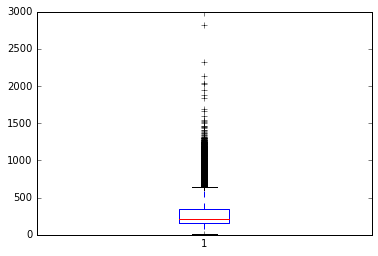

In [5]:
#Summarize review length
#We can see that the average review has just under 300 words with a standard deviation of just over 200 words.
print "Review length.."
result = map(len, X_train)
print("mean %.2f, words (%f)" % (np.mean(result), np.std(result)))
"Plot review length"
plt.boxplot(result)
plt.show()

Looking a box and whisker plot for the review lengths in words, we can probably see an exponential distribution that we can probably cover the mass of the distribution with a clipped length of 400 to 500 words.

A recent breakthrough in the field of natural language processing is called word embedding.

This is a technique where words are encoded as real-valued vectors in a high dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.

Discrete words are mapped to vectors of continuous numbers. This is useful when working with natural language problems with neural networks and deep learning models are we require numbers as input.

Keras provides a convenient way to convert positive integer representations of words into a word embedding by an Embedding layer.

The layer takes arguments that define the mapping including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value that will be seen as an integer). The layer also allows you to specify the dimensionality for each word vector, called the output dimension.

We would like to use a word embedding representation for the IMDB dataset.

Let’s say that we are only interested in the first 5,000 most used words in the dataset. Therefore our vocabulary size will be 5,000. We can choose to use a 32-dimension vector to represent each word. Finally, we may choose to cap the maximum review length at 500 words, truncating reviews longer than that and padding reviews shorter than that with 0 values.

We would load the IMDB dataset as follows:

In [6]:
imdb.load_data(nb_words=5000, test_split=0.33)

((array([ [1, 20, 28, 716, 48, 495, 79, 27, 493, 8, 2, 7, 50, 5, 4682, 2, 10, 5, 852, 157, 11, 5, 1716, 3351, 10, 5, 500, 2, 6, 33, 256, 41, 2, 7, 17, 23, 48, 1537, 3504, 26, 269, 929, 18, 2, 7, 2, 4284, 8, 105, 5, 2, 182, 314, 38, 98, 103, 7, 36, 2184, 246, 360, 7, 19, 396, 17, 26, 269, 929, 18, 1769, 493, 6, 116, 7, 105, 5, 575, 182, 27, 5, 1002, 1085, 130, 62, 17, 24, 89, 17, 13, 381, 1421, 8, 2, 7, 5, 2723, 38, 325, 7, 17, 23, 93, 9, 156, 252, 19, 235, 20, 28, 5, 104, 76, 7, 17, 169, 35, 2, 17, 23, 1460, 7, 36, 2184, 934, 56, 2134, 6, 17, 891, 214, 11, 5, 1552, 6, 92, 6, 33, 256, 82, 7],
         [1, 621, 6, 135, 101, 84, 392, 27, 20, 133, 1522, 63, 2, 2, 896, 11, 213, 149, 9, 417, 180, 1748, 32, 63, 31, 525, 7, 78, 42, 147, 66, 644, 113, 89, 8, 21, 147, 89, 13, 1851, 3994, 43, 170, 6, 60, 21, 296, 35, 1310, 214, 6, 789, 2, 7, 15, 16, 12, 14, 15, 16, 12, 14, 5, 927, 10, 5, 2, 13, 62, 23, 652, 25, 2046, 927, 7, 73, 574, 49, 5, 2, 1264, 56, 135, 46, 38, 6, 5, 191, 342, 10, 2, 10, 2, 

We would then use the Keras utility to truncate or pad the dataset to a length of 500 for each observation using the sequence.pad_sequences() function.

In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=500)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=500)

Finally, later on, the first layer of our model would be an word embedding layer created using the Embedding class as follows:

In [8]:
keras.layers.embeddings.Embedding(5000, 32, input_length=500)

Simple Multi-Layer Perceptron Model for the IMDB Dataset

We can start off by developing a simple multi-layer perceptron model with a single hidden layer.

The word embedding representation is a true innovation and we will demonstrate what would have been considered world class results in 2011 with a relatively simple neural network.

Let’s start off by importing the classes and functions required for this model and initializing the random number generator to a constant value to ensure we can easily reproduce the results.

In [9]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [10]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
test_split = 0.33
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, test_split=test_split)

In [11]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

Now we can create our model. We will use an Embedding layer as the input layer, setting the vocabulary to 5,000, the word vector size to 32 dimensions and the input_length to 500. The output of this first layer will be a 32×500 sized matrix as discussed in the previous section.

We will flatten the Embedded layers output to one dimension, then use one dense hidden layer of 250 units with a rectifier activation function. The output layer has one neuron and will use a sigmoid activation to output values of 0 and 1 as predictions.

The model uses logarithmic loss and is optimized using the efficient ADAM optimization procedure.

In [12]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 500, 32)       160000      embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 16000)         0           embedding_2[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 250)           4000250     flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             251         dense_1[0][0]                    
Total params: 4160501
_____________________________________________________________________

We can fit the model and use the test set as validation while training. This model overfits very quickly so we will use very few training epochs, in this case just 2.

There is a lot of data so we will use a batch size of 128. After the model is trained, we evaluate it’s accuracy on the test dataset.

In [13]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 16750 samples, validate on 8250 samples
Epoch 1/2
16750/16750 [==============================] - 70s - loss: 0.5616 - acc: 0.6785 - val_loss: 0.3420 - val_acc: 0.8573
Epoch 2/2
16750/16750 [==============================] - 70s - loss: 0.2027 - acc: 0.9219 - val_loss: 0.3299 - val_acc: 0.8627
Accuracy: 86.27%


Running this example fits the model and summarizes the estimated performance. We can see that this very simple model achieves a score of 86.27% which is in the neighborhood of the original paper, with very little effort.

I’m sure we can do better if we trained this network, perhaps using a larger embedding and adding more hidden layers. Let’s try a different network type.

One-Dimensional Convolutional Neural Network Model for the IMDB Dataset

Convolutional neural networks were designed to honor the spatial structure in image data whilst being robust to the position and orientation of learned objects in the scene.

This same principle can be used on sequences, such as the one-dimensional sequence of words in a movie review. The same properties that make the CNN model attractive for learning to recognize objects in images can help to learn structure in paragraphs of words, namely the techniques invariance to the specific position of features.

Keras supports one dimensional convolutions and pooling by the Convolution1D and MaxPooling1D classes respectively.

Again, let’s import the classes and functions needed for this example and initialize our random number generator to a constant value so that we can easily reproduce results.

In [14]:
# CNN for the IMDB problem
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Convolution1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

In [15]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
test_split = 0.33
(X_train, y_train), (X_test, y_test) = imdb.load_data(nb_words=top_words, test_split=test_split)
# pad dataset to a maximum review length in words
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

We can now define our convolutional neural network model. This time, after the Embedding input layer, we insert a Convolution1D layer. This convolutional layer has 32 feature maps and reads embedded word representations 3 vector elements of the word embedding at a time.

The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.

In [16]:
# create the model
model = Sequential()
model.add(Embedding(top_words, 32, input_length=max_words))
model.add(Convolution1D(nb_filter=32, filter_length=3, border_mode='same', activation='relu'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_3 (Embedding)          (None, 500, 32)       160000      embedding_input_2[0][0]          
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 500, 32)       3104        embedding_3[0][0]                
____________________________________________________________________________________________________
maxpooling1d_1 (MaxPooling1D)    (None, 250, 32)       0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 8000)          0           maxpooling1d_1[0][0]             
___________________________________________________________________________________________

In [17]:
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=2, batch_size=128, verbose=1)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

ERROR (theano.gof.opt): Optimization failure due to: local_abstractconv_check
ERROR (theano.gof.opt): node: AbstractConv2d{border_mode='half', subsample=(1, 1), filter_flip=True, imshp=(None, None, None, None), kshp=(None, None, None, None)}(DimShuffle{0,2,1,x}.0, convolution1d_1_W)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "C:\Users\ritraina\Anaconda2.4\lib\site-packages\theano\gof\opt.py", line 1772, in process_node
    replacements = lopt.transform(node)
  File "C:\Users\ritraina\Anaconda2.4\lib\site-packages\theano\tensor\nnet\opt.py", line 402, in local_abstractconv_check
    node.op.__class__.__name__)
AssertionError: AbstractConv2d Theano optimization failed: there is no implementation available supporting the requested options. Did you exclude both "conv_dnn" and "conv_gemm" from the optimizer? If on GPU, is cuDNN available and does the GPU support it? If on CPU, do you have a BLAS library installed Theano can link agai

AssertionError: AbstractConv2d Theano optimization failed: there is no implementation available supporting the requested options. Did you exclude both "conv_dnn" and "conv_gemm" from the optimizer? If on GPU, is cuDNN available and does the GPU support it? If on CPU, do you have a BLAS library installed Theano can link against?

Accuracy: 88.48%
Again, there is a lot of opportunity for further optimization, such as the use of deeper and/or larger convolutional layers. One interesting idea is to set the max pooling layer to use an input length of 500. This would compress each feature map to a single 32 length vector and may boost performance.

Summary

In this post you discovered the IMDB sentiment analysis dataset for natural language processing.

You learned how to develop deep learning models for sentiment analysis including:

How to load and review the IMDB dataset within Keras.
How to develop a large neural network model for sentiment analysis.
How to develop a one-dimensional convolutional neural network model for sentiment analysis.